In [116]:
# Virgil's Hardest Sentence?: Measuring Readability in Latin Poetry

An iPython notebook to demonstrate the use of the Classical Language Toolkit for a preliminary investigation of readability measurements for Latin literature, with an emphasis on poetry.

Presented at Ohio University, 4/21/17.
Status: DRAFT (4/17/17)

Project arose from a conversation with Latin & Greek teachers this summer about how much reading to assign to their intermediate students per class. Each teacher had a different suggestion of how many "lines per class" their students could "handle", and varying perspectives on how "hard" different authors/work were, how long it would take their students to complete assignments, etc. Each teacher brought to the conversation years, even decades of teaching experience to support their arguments for more or less material to assign. Such qualitative expertise cannot be discounted. At the same time, I happened to be working on natural language processing tool development for the Classical Language Toolkit at the time and became interested in ways in which the formal measurements (word length, sentence length, lexical diversity, etc.) made available by the CLTK could help teachers develop a quanititative basis on which to make decisions about assignments. I began to look into the subject of "readability" and work in English and decided to start evaluating these kinds of methods for classical languages.

So the long-term goals of this project are:
    1. to develop objective measurements for comparing different Latin authors, works, parts of works, etc.
    2. to use comparative measurements to allow students to be matched with reading material at an appropriate level, but especially to help emergent readers move from textbooks to reading Latin texts with the least amount of difficulty

## Imports

In [117]:
import os
import re
import csv
import string
import html

from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np

from cltk.corpus.latin import latinlibrary
from cltk.tokenize.sentence import TokenizeSentence
from cltk.tokenize.word import WordTokenizer
from cltk.lemmatize.latin.backoff import BackoffLatinLemmatizer
from cltk.stem.latin.j_v import JVReplacer
from cltk.utils.file_operations import open_pickle

## Data

For this study, I am using the works of Cicero as found on the site **The Latin Library** (thelatinlibrary.com). The Latin Library is available from the CLTK as a plaintext corpus. Since it is freely and easily available in this format, it is an ideal choice for a preliminary investigation of these words.

The corpus can be loaded into Python (assuming the current version of CLTK is installed) with the following command:

In [118]:
from cltk.corpus.latin import latinlibrary

### Process Files

In [119]:
files = latinlibrary.fileids()
print(len(files))
print(files[:10])

2162
['12tables.txt', '1644.txt', 'abbofloracensis.txt', 'abelard/dialogus.txt', 'abelard/epistola.txt', 'abelard/historia.txt', 'addison/barometri.txt', 'addison/burnett.txt', 'addison/hannes.txt', 'addison/machinae.txt']


We need to extract only the files we need, specifically the works of Virgil, from the 2,162 files that are in the Latin Library corpus.

In [120]:
vergil_files = [file for file in files if 'vergil/' in file]

print(len(vergil_files),'\n')
pprint(vergil_files)

26 

['vergil/aen1.txt',
 'vergil/aen10.txt',
 'vergil/aen11.txt',
 'vergil/aen12.txt',
 'vergil/aen2.txt',
 'vergil/aen3.txt',
 'vergil/aen4.txt',
 'vergil/aen5.txt',
 'vergil/aen6.txt',
 'vergil/aen7.txt',
 'vergil/aen8.txt',
 'vergil/aen9.txt',
 'vergil/ec1.txt',
 'vergil/ec10.txt',
 'vergil/ec2.txt',
 'vergil/ec3.txt',
 'vergil/ec4.txt',
 'vergil/ec5.txt',
 'vergil/ec6.txt',
 'vergil/ec7.txt',
 'vergil/ec8.txt',
 'vergil/ec9.txt',
 'vergil/geo1.txt',
 'vergil/geo2.txt',
 'vergil/geo3.txt',
 'vergil/geo4.txt']


As we see in the cell above, we can get these files by matching on the directory 'vergil/'.

###### So, our data consists of 26 plaintext files of the works of Vergil.

Here is an idea of what the files look like when we load them:

In [121]:
print(latinlibrary.raw(vergil_files[0])[:1000])

Vergil: Aeneid I
		 

		 
		
		 
		
		 
		 
	 
	
 


 P. VERGILI MARONIS AENEIDOS LIBER PRIMVS 


 

Arma virumque cano, Troiae qui primus ab oris 
Italiam, fato profugus, Laviniaque venit 
litora, multum ille et terris iactatus et alto 
vi superum saevae memorem Iunonis ob iram; 
multa quoque et bello passus, dum conderet urbem,    5 
inferretque deos Latio, genus unde Latinum, 
Albanique patres, atque altae moenia Romae.
 

 
Musa, mihi causas memora, quo numine laeso, 
quidve dolens, regina deum tot volvere casus 
insignem pietate virum, tot adire labores    10 
impulerit. Tantaene animis caelestibus irae?
 

 
Urbs antiqua fuit, Tyrii tenuere coloni, 
Karthago, Italiam contra Tiberinaque longe 
ostia, dives opum studiisque asperrima belli; 
quam Iuno fertur terris magis omnibus unam    15 
posthabita coluisse Samo; hic illius arma, 
hic currus fuit; hoc regnum dea gentibus esse, 
si qua fata sinant, iam tum tenditque fovetque. 
Progeniem sed enim Troiano a sanguine duci 
audierat, 

We need to preprocess these texts before we can do meaningful work with them. For this we will use a combination of built-in Python methods and modules designed specifically for Latin found in the CLTK.

The first thing we will do is make a list of the unprocessed texts, i.e. a list of *very* long strings, each a work of Cicero found in the Latin Library.

In [123]:
vergil_texts = [latinlibrary.raw(file) for file in vergil_files]

print(len(vergil_texts))

26


And let's keep things orderly by keeping a list of titles. Since the first line of every LL page contains the work's title, we can iterate over our texts and capture this information.

In [124]:
vergil_titles = ['Aen. 1', 'Aen. 10', 'Aen. 11', 'Aen. 12', 'Aen. 2', 'Aen. 3', 
                 'Aen. 4', 'Aen. 5', 'Aen. 6', 'Aen. 7', 'Aen. 8', 'Aen. 9',
                 'Ecl. 1', 'Ecl. 10', 'Ecl. 2', 'Ecl. 3', 'Ecl. 4', 'Ecl. 5',
                 'Ecl. 6', 'Ecl. 7', 'Ecl. 8', 'Ecl. 9', 'Geo. 1', 'Geo. 2',
                 'Geo. 3', 'Geo. 4'] 

print(len(vergil_titles),'\n')
pprint(vergil_titles)

26 

['Aen. 1',
 'Aen. 10',
 'Aen. 11',
 'Aen. 12',
 'Aen. 2',
 'Aen. 3',
 'Aen. 4',
 'Aen. 5',
 'Aen. 6',
 'Aen. 7',
 'Aen. 8',
 'Aen. 9',
 'Ecl. 1',
 'Ecl. 10',
 'Ecl. 2',
 'Ecl. 3',
 'Ecl. 4',
 'Ecl. 5',
 'Ecl. 6',
 'Ecl. 7',
 'Ecl. 8',
 'Ecl. 9',
 'Geo. 1',
 'Geo. 2',
 'Geo. 3',
 'Geo. 4']


### NLP Workflow

(Load corpus) > Preprocess > Tokenize > Stem, Lemmatize, POS-Tag, etc. > Process

### CLTK Tools

Quick aside about the tools I will be using for this text analysis project. I am a contributor to the Classical Language Toolkit, specifically working on improving the tokenization, lemmatization, POS-tagging, etc. available for the Latin tools. The project can be found at cltk.org. For a brief overview of what the CLTK offers, I recommend this slide deck: https://t.co/lz7SwwJvab

The Latin CLTK tools I will use today include:
- sentence tokenizer 
- word tokenizer
- lemmatizer
- J/V replacer

In [125]:
# Set up training sentences

rel_path = os.path.join('~/cltk_data/latin/model/latin_models_cltk/lemmata/backoff')
path = os.path.expanduser(rel_path)

# Check for presence of latin_pos_lemmatized_sents
file = 'latin_pos_lemmatized_sents.pickle'      

latin_pos_lemmatized_sents_path = os.path.join(path, file)
if os.path.isfile(latin_pos_lemmatized_sents_path):
    latin_pos_lemmatized_sents = open_pickle(latin_pos_lemmatized_sents_path)
else:
    latin_pos_lemmatized_sents = []
    print('The file %s is not available in cltk_data' % file)  

In [126]:
word_tokenizer = WordTokenizer('latin')
sent_tokenizer = TokenizeSentence('latin')
lemmatizer = BackoffLatinLemmatizer(latin_pos_lemmatized_sents)
replacer = JVReplacer()

In [127]:
# We will use a custom sentence tokenizer here—namely one that can split on sentences without removing new lines.

def tsplit(s, sep):
    # http://code.activestate.com/recipes/577616-split-strings-w-multiple-separators/
    stack = [s]
    for char in sep:
        pieces = []
        for substr in stack:
            pieces.extend(substr.split(char))
        stack = pieces
    return stack

### Function for preprocessing texts

In [206]:
def preprocess(text):    

    text = html.unescape(text) # Handle html entities
    text = re.sub(r'&nbsp;?', ' ',text) #&nbsp; stripped incorrectly in corpus?
    text = re.sub('\x00',' ',text) #Another space problem?
    
    text = text.lower()
    text = replacer.replace(text) #Normalize u/v & i/j
    
    #punctuation ="\"#$%&\'()*+,-/:;<=>@[\]^_`{|}~.?!«»"
    punctuation ="—\"#$%&\'()*+,-/:;<=>@[\]^_`{|}~«»"
    translator = str.maketrans({key: " " for key in punctuation})
    text = text.translate(translator)
    
    translator = str.maketrans({key: " " for key in '0123456789'})
    text = text.translate(translator)

    remove_list = [r'\bthe latin library\b',
                   r'\bthe classics page\b',
                   r'\bneo-latin\b', 
                   r'\bmedieval latin\b',
                   r'\bchristian latin\b',
                   r'\bchristina latin\b',
                   r'\bpapal bulls\b',
                   r'\bthe miscellany\b',
                  ]

    for pattern in remove_list:
        text = re.sub(pattern, '', text)
        
    remove_list = [r'\bp. uergili maronis .+? liber .+?\b',
                    r'\bp. uergili maronis ecloga .+?\b',
                    r'\buergil\b', 
                    r'\baeneid .+?\b',
                    r'^\s+?menalcas\s+?$',
                    r'^\s+?damoetas\s+?$',
                    r'^\s+?mopsus\s+?$',
                    r'^\s+?meliboeus\s+?$',
                    r'^\s+?corydon\s+?$',
                    r'^\s+?thyrsis\s+?$',
                    r'^\s+?lycidas\s+?$',
                    r'^\s+?moeris\s+?$',
                    r'^\s+?tityrus\s+?$',
                  ]

    for pattern in remove_list:
        text = re.sub(pattern, '', text)
    
    #text = re.sub('[ ]+',' ', text) # Remove double spaces
    #text = re.sub('\s+\n+\s+','\n', text) # Remove double lines and trim spaces around new lines; Working?
    #text = re.sub(r'^ ','', text)
    #text = re.sub(r' \n','\n', text)
    #text = re.sub(r'[?!]','.', text) # Replace all remaining sentence-boundary punctuation with period for easy tokenization.
    
    return text.strip()


### Preprocess Texts

In [212]:
vergil_texts = [preprocess(text) for text in vergil_texts]

#print('\nBEFORE: \n ----------')
#print(latinlibrary.raw(vergil_files[12])[:1000])

print('\nAfter: \n ----------')
print(vergil_texts[12][:1000])


After: 
 ----------
meliboeus tityre tu patulae recubans sub tegmine fagi 
siluestrem tenui musam meditaris auena 
nos patriae fines et dulcia linquimus arua. 
nos patriam fugimus tu tityre lentus in umbra 
formosam resonare doces amaryllida siluas.
tityrus o meliboee deus nobis haec otia fecit. 
namque erit ille mihi semper deus illius aram 
saepe tener nostris ab ouilibus imbuet agnus. 
ille meas errare boues ut cernis et ipsum 
ludere quae uellem calamo permisit agresti.
meliboeus non equidem inuideo miror magis undique totis 
usque adeo turbatur agris. en ipse capellas 
protenus aeger ago hanc etiam uix tityre duco. 
hic inter densas corylos modo namque gemellos 
spem gregis a silice in nuda conixa reliquit. 
saepe malum hoc nobis si mens non laeua fuisset 
de caelo tactas memini praedicere quercus. 
sed tamen iste deus qui sit da tityre nobis.
tityrus urbem quam dicunt romam meliboee putaui 
stultus ego huic nostrae similem cui saepe solemus 
pastores ouium teneros depellere fetu

In [208]:
vergil_texts = [preprocess(text) for text in vergil_texts]

print('\nBEFORE: \n ----------')
print(latinlibrary.raw(vergil_files[0])[:1000])

print('\nAfter: \n ----------')
print(vergil_texts[0][:1000])


BEFORE: 
 ----------
Vergil: Aeneid I
		 

		 
		
		 
		
		 
		 
	 
	
 


 P. VERGILI MARONIS AENEIDOS LIBER PRIMVS 


 

Arma virumque cano, Troiae qui primus ab oris 
Italiam, fato profugus, Laviniaque venit 
litora, multum ille et terris iactatus et alto 
vi superum saevae memorem Iunonis ob iram; 
multa quoque et bello passus, dum conderet urbem,    5 
inferretque deos Latio, genus unde Latinum, 
Albanique patres, atque altae moenia Romae.
 

 
Musa, mihi causas memora, quo numine laeso, 
quidve dolens, regina deum tot volvere casus 
insignem pietate virum, tot adire labores    10 
impulerit. Tantaene animis caelestibus irae?
 

 
Urbs antiqua fuit, Tyrii tenuere coloni, 
Karthago, Italiam contra Tiberinaque longe 
ostia, dives opum studiisque asperrima belli; 
quam Iuno fertur terris magis omnibus unam    15 
posthabita coluisse Samo; hic illius arma, 
hic currus fuit; hoc regnum dea gentibus esse, 
si qua fata sinant, iam tum tenditque fovetque. 
Progeniem sed enim Troiano a san

We now have a list of preprocessed text files which we can use for our readability measurements.

## Classic Readability

Classic readability refers to the measurement of relative ease and difficult of reading material through two main measurements:

- Sentence length (primarily measured in number of words)
- Lexical difficulty

Dale Chall (1949, 1) defined the "success" of reading any given passage as the "extent to which [readers] understand it, read it at an optimal speed, and find it interesting." The first stage of my research on readability will deal with only the first, and to a lesser degree the second, of these criteria.

Much work has been done on lexical difficulty and diversity in Classics. Less attention has been paid to formal features such as word/sentence length, character/syllable counts, etc. (This is at least true with respect to readability; stylometry in Classics has a richer quantitative tradition in these matters.) That said, it has always been implicitly understood that formal features are related ease of reading, as the images below illustrate:

#### Pedagogical value of sentence length for Latin
##### "Sentences of two words"

<img src="img/two_words.jpg">

#### Pedagogical value of sentence length for Latin
##### "Sententiae plurium dictionum", i.e. "sentences of more words"

<img src="img/more_words.jpg">

from Hoole's 1658 *Sententiae pueriles anglo-latinae*
https://books.google.com/books?id=i_9mAAAAcAAJ

The idea that shorter sentences are easier for emergent readers to learn may appear self-evident, and, even in Latin pedagogy, the early placement in the curriculum of the Monostichs / Distichs of Cato, the sententiae of Publilius Syrus, and similar material, confirms this. The modern equivalent can be seen in the average length of sentences in Chapter 1 of Wheelock versus Chapter 40. At the same time, sentence length is variable and it still remains a valid question to ask—how many words are in a short sentence? and by extension, how many words can be in a sentence before it becomes difficult to read?

Note: So-called "classic" readability can be distinguished from new trends in readability study with a cognitive psychological or linguistic approach.

### Lexical Diversity

Like any data scientist, we probably want to do some basic exploration of our data to get an idea of what we are working with. This can take many forms with textual data. We know how many texts we are working with. How about we get an idea of how long each text is?

Let's start by tokenizing the data into several levels that will be useful to us as we continue working.

In [13]:
# Remove paragraphs less than 10 words long
# cicero_paras = []

for text in cicero_texts:
    paras = text.split('\n')
    paras = [" ".join(para.split()) for para in paras]
    paras = [para for para in paras if len(para.split()) > 10]
    cicero_paras.append(paras)

print(len(cicero_paras))
print(cicero_paras[0][:2])

137
['in cumano nuper cum mecum atticus noster esset nuntiatum est nobis a m. varrone venisse eum roma pridie vesperi et nisi de via fessus esset continuo ad nos venturum fuisse. quod cum audissemus nullam moram interponendam putavimus quin videremus hominem nobiscum et studiis eisdem et vetustate amicitiae coniunctum itaque confestim ad eum ire perreximus. paulumque cum ab eius villa abessemus ipsum ad nos venientem vidimus atque illum complexi ut mos amicorum est satis enim longo inter vallo ad suam villam reduximus.', 'hic pauca primo atque ea percunctantibus nobis ecquid forte roma novi. tum atticus omitte ista quae nec percunctari nec audire sine molestia possumus quaeso inquit et quaere potius ecquid ipse novi. silent enim diutius musae varronis quam solebant nec tamen istum cessare sed celare quae scribat existimo. minime vero inquit ille intemperantis enim arbitror esse scribere quod occultari velit sed habeo magnum opus in manihus quae iam pridem ad hunc enim ipsum me autem di

In [14]:
cicero_sents = []

for paras in cicero_paras:
    temp = []
    for para in paras:
        sents = sent_tokenizer.tokenize(para)
        sents = [sent for sent in sents if len(sent.split()) > 5]
        temp.append(sents)
    cicero_sents.append(temp)

print(len(cicero_sents))
print(cicero_sents[0][:2])

137
[['in cumano nuper cum mecum atticus noster esset nuntiatum est nobis a m. varrone venisse eum roma pridie vesperi et nisi de via fessus esset continuo ad nos venturum fuisse.', 'quod cum audissemus nullam moram interponendam putavimus quin videremus hominem nobiscum et studiis eisdem et vetustate amicitiae coniunctum itaque confestim ad eum ire perreximus.', 'paulumque cum ab eius villa abessemus ipsum ad nos venientem vidimus atque illum complexi ut mos amicorum est satis enim longo inter vallo ad suam villam reduximus.'], ['hic pauca primo atque ea percunctantibus nobis ecquid forte roma novi.', 'tum atticus omitte ista quae nec percunctari nec audire sine molestia possumus quaeso inquit et quaere potius ecquid ipse novi.', 'silent enim diutius musae varronis quam solebant nec tamen istum cessare sed celare quae scribat existimo.', 'minime vero inquit ille intemperantis enim arbitror esse scribere quod occultari velit sed habeo magnum opus in manihus quae iam pridem ad hunc enim

In [84]:
vergil_tokens = []
for text in vergil_texts:
    tokens = word_tokenizer.tokenize(text)
    tokens = [token for token in tokens if token not in '.?!']
    vergil_tokens.append(tokens)

print(len(vergil_tokens))
print(vergil_tokens[0][:100])

26
['arma', 'uirum', '-que', 'cano', 'troiae', 'qui', 'primus', 'ab', 'oris', 'italiam', 'fato', 'profugus', 'lauinia', '-que', 'uenit', 'litora', 'multum', 'ille', 'et', 'terris', 'iactatus', 'et', 'alto', 'ui', 'superum', 'saeuae', 'memorem', 'iunonis', 'ob', 'iram', 'multa', 'quoque', 'et', 'bello', 'passus', 'dum', 'conderet', 'urbem', 'inferret', '-que', 'deos', 'latio', 'genus', 'unde', 'latinum', 'albani', '-que', 'patres', 'atque', 'altae', 'moenia', 'romae', 'musa', 'mihi', 'causas', 'memora', 'quo', 'numine', 'laeso', 'quid', '-ue', 'dolens', 'regina', 'deum', 'tot', 'uoluere', 'casus', 'insignem', 'pietate', 'uirum', 'tot', 'adire', 'labores', 'impulerit', 'tantae', '-ne', 'animis', 'caelestibus', 'irae', 'urbs', 'antiqua', 'fuit', 'tyrii', 'tenuere', 'coloni', 'karthago', 'italiam', 'contra', 'tiberina', '-que', 'longe', 'ostia', 'diues', 'opum', 'studiis', '-que', 'asperrima', 'belli', 'quam', 'iuno']


In [16]:
# Length of work
lengths = []

for i, tokens in enumerate(cicero_tokens):
    lengths.append((cicero_titles[i], len(tokens)))

lengths.sort(key=lambda x: x[1])
pprint(lengths[:5])
pprint(lengths[-5:])

[('cicero: de re publica iv', 211),
 ('cicero: de re publica v', 389),
 ('cicero: de lege agraria iii', 1281),
 ('cicero: philippic iv', 1400),
 ('cicero: de optimo genere oratorum', 1602)]
[('cicero: in verrem ii.5', 19477),
 ('pro a. clventio oratio', 21013),
 ('cicero: in verrem ii.3', 25178),
 ('brutus', 25365),
 ('cicero: de oratore ii', 27390)]


Min:  211 ( cicero: de re publica iv )
Mean:  8241.93430657
Max:  27390 ( cicero: de oratore ii )


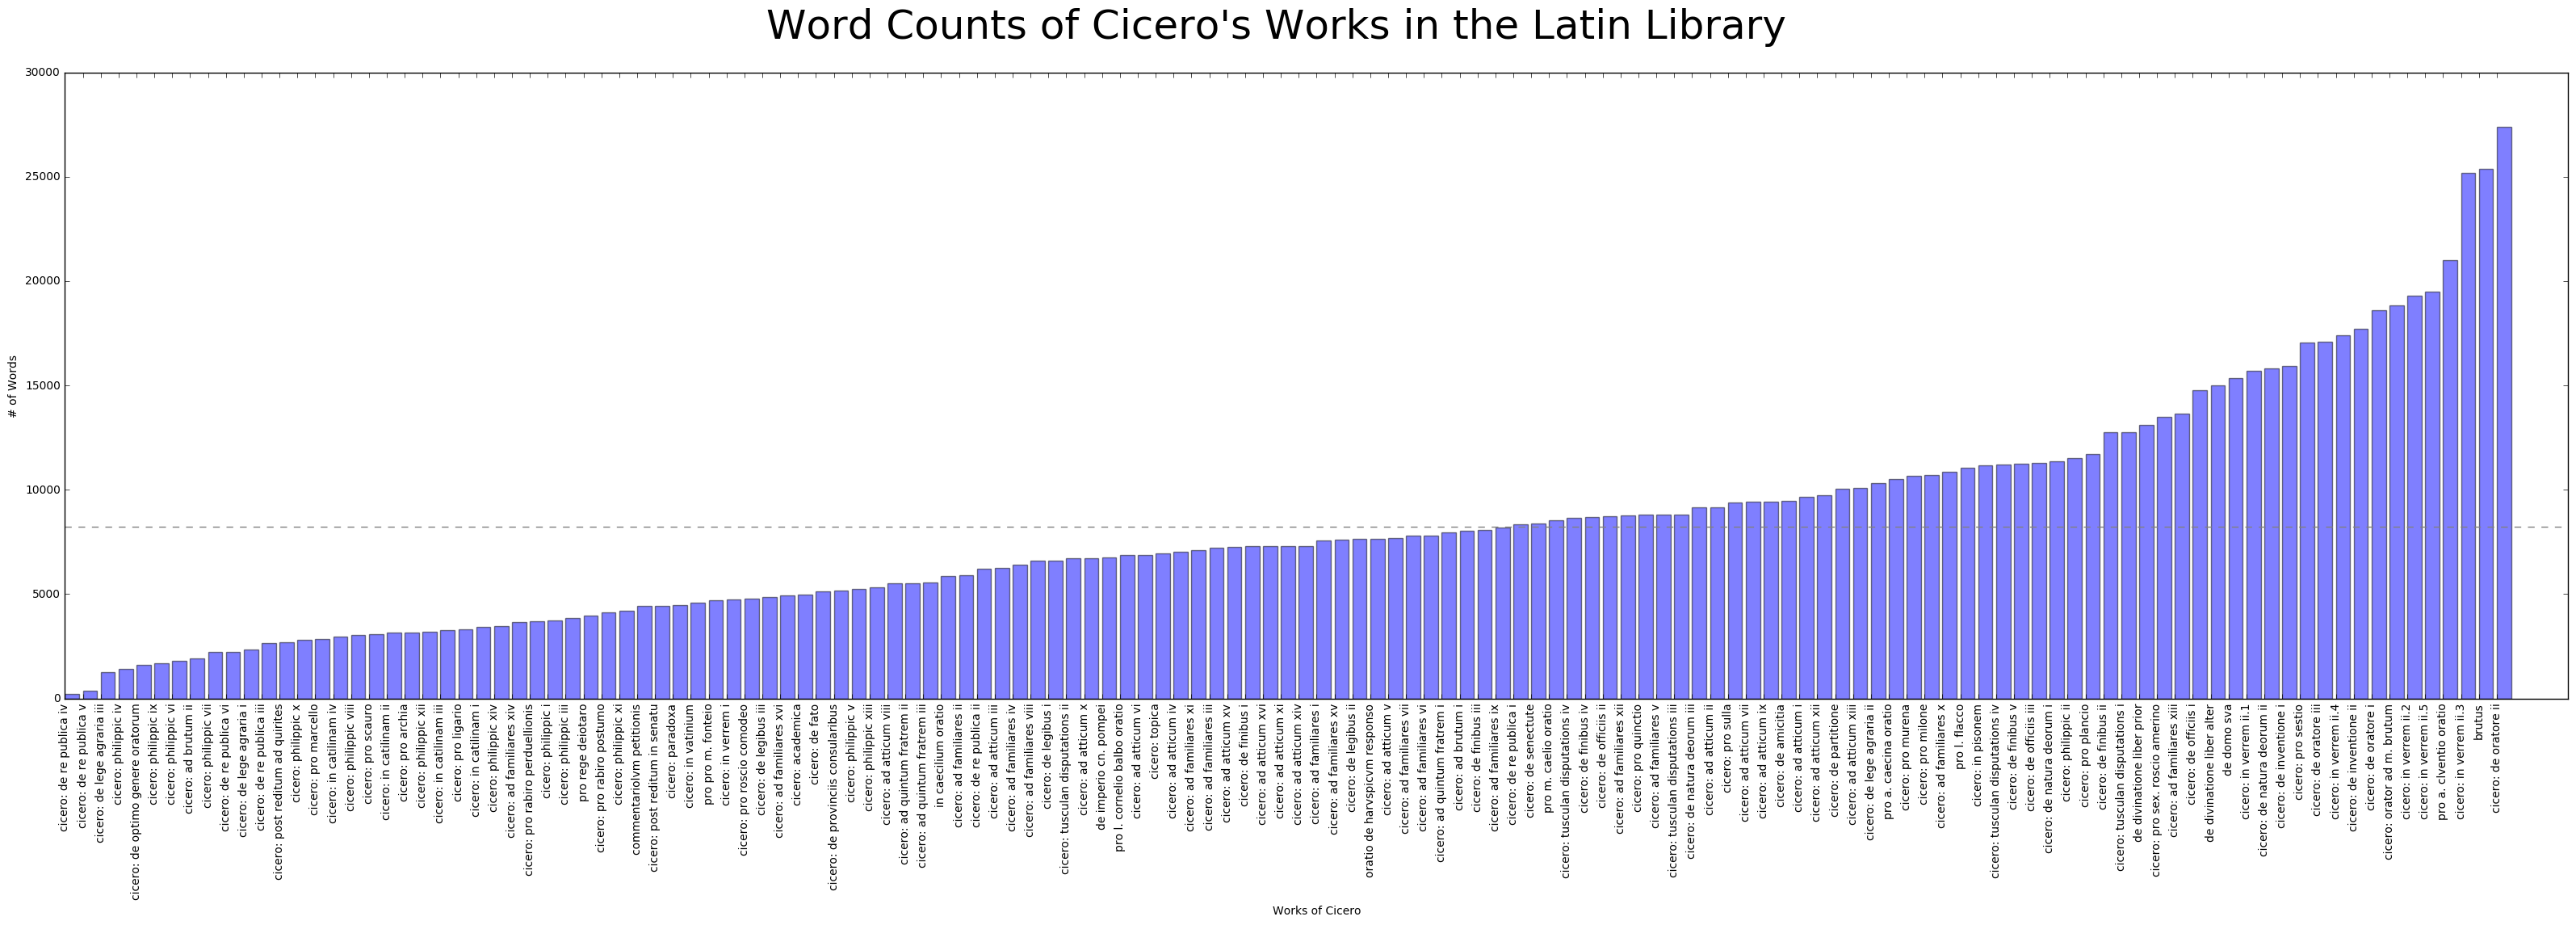

In [17]:
objects = [item[0] for item in lengths]
scores = [item[1] for item in lengths]
min_score = min(scores)
mean_score = np.mean(scores)
max_score = max(scores)

print('Min: ', min_score, '(', objects[scores.index(min_score)], ')')
print('Mean: ', mean_score)
print('Max: ', max_score, '(', objects[scores.index(max_score)], ')')

y_pos = np.arange(len(objects))
plt.figure(figsize=(40,10))
barlist = plt.bar(y_pos, scores, alpha=.5)
plt.xticks(y_pos, objects)
plt.axhline(y=mean_score,color='gray',ls='dashed')
plt.suptitle('Word Counts of Cicero\'s Works in the Latin Library', fontsize=36)
plt.xlabel('Works of Cicero')
plt.ylabel('# of Words')

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.show()

Perhaps of more use as we start to think about readability would be a measurement of lexical diversity, i.e. "the number of times each vocabulary item appears in the text on average" (from NLTK Ch. 2). We can compute this figure by taking the total number of 'words' in a text as the denominator, taking the number of unique 'words' as the numerator, and dividing. We have the total, and since we have a list of tokens, it is easy to get the set of unique words.

In [88]:
# Unique words
uniques = []

for i, tokens in enumerate(vergil_tokens):
    uniques.append((vergil_titles[i], len(set(tokens))))

uniques.sort(key=lambda x: x[1])
pprint(uniques[:5])
pprint(uniques[-5:])

[('Ecl. 4', 339),
 ('Ecl. 9', 358),
 ('Ecl. 7', 364),
 ('Ecl. 10', 387),
 ('Ecl. 2', 393)]
[('Aen. 7', 3067),
 ('Aen. 10', 3131),
 ('Aen. 11', 3158),
 ('Aen. 12', 3188),
 ('Aen. 6', 3235)]


In [91]:
# Lexical diversity
lexdivs = []

for i, tokens in enumerate(vergil_tokens):
    lexdivs.append((vergil_titles[i], len(set(tokens)) / len(tokens)))

lexdivs.sort(key=lambda x: x[1])
pprint(lexdivs[:5])
pprint(lexdivs[-5:])

[('Aen. 12', 0.4881335170724238),
 ('Aen. 10', 0.5041056190629528),
 ('Aen. 11', 0.5054417413572343),
 ('Aen. 5', 0.506693780715133),
 ('Aen. 2', 0.5082206795761783)]
[('Ecl. 9', 0.716),
 ('Ecl. 1', 0.7491467576791809),
 ('Ecl. 2', 0.7528735632183908),
 ('Ecl. 6', 0.7650085763293311),
 ('Ecl. 4', 0.7793103448275862)]


Min:  0.4881335170724238 ( Aen. 12 )
Mean:  0.609784728049
Max:  0.7793103448275862 ( Ecl. 4 )


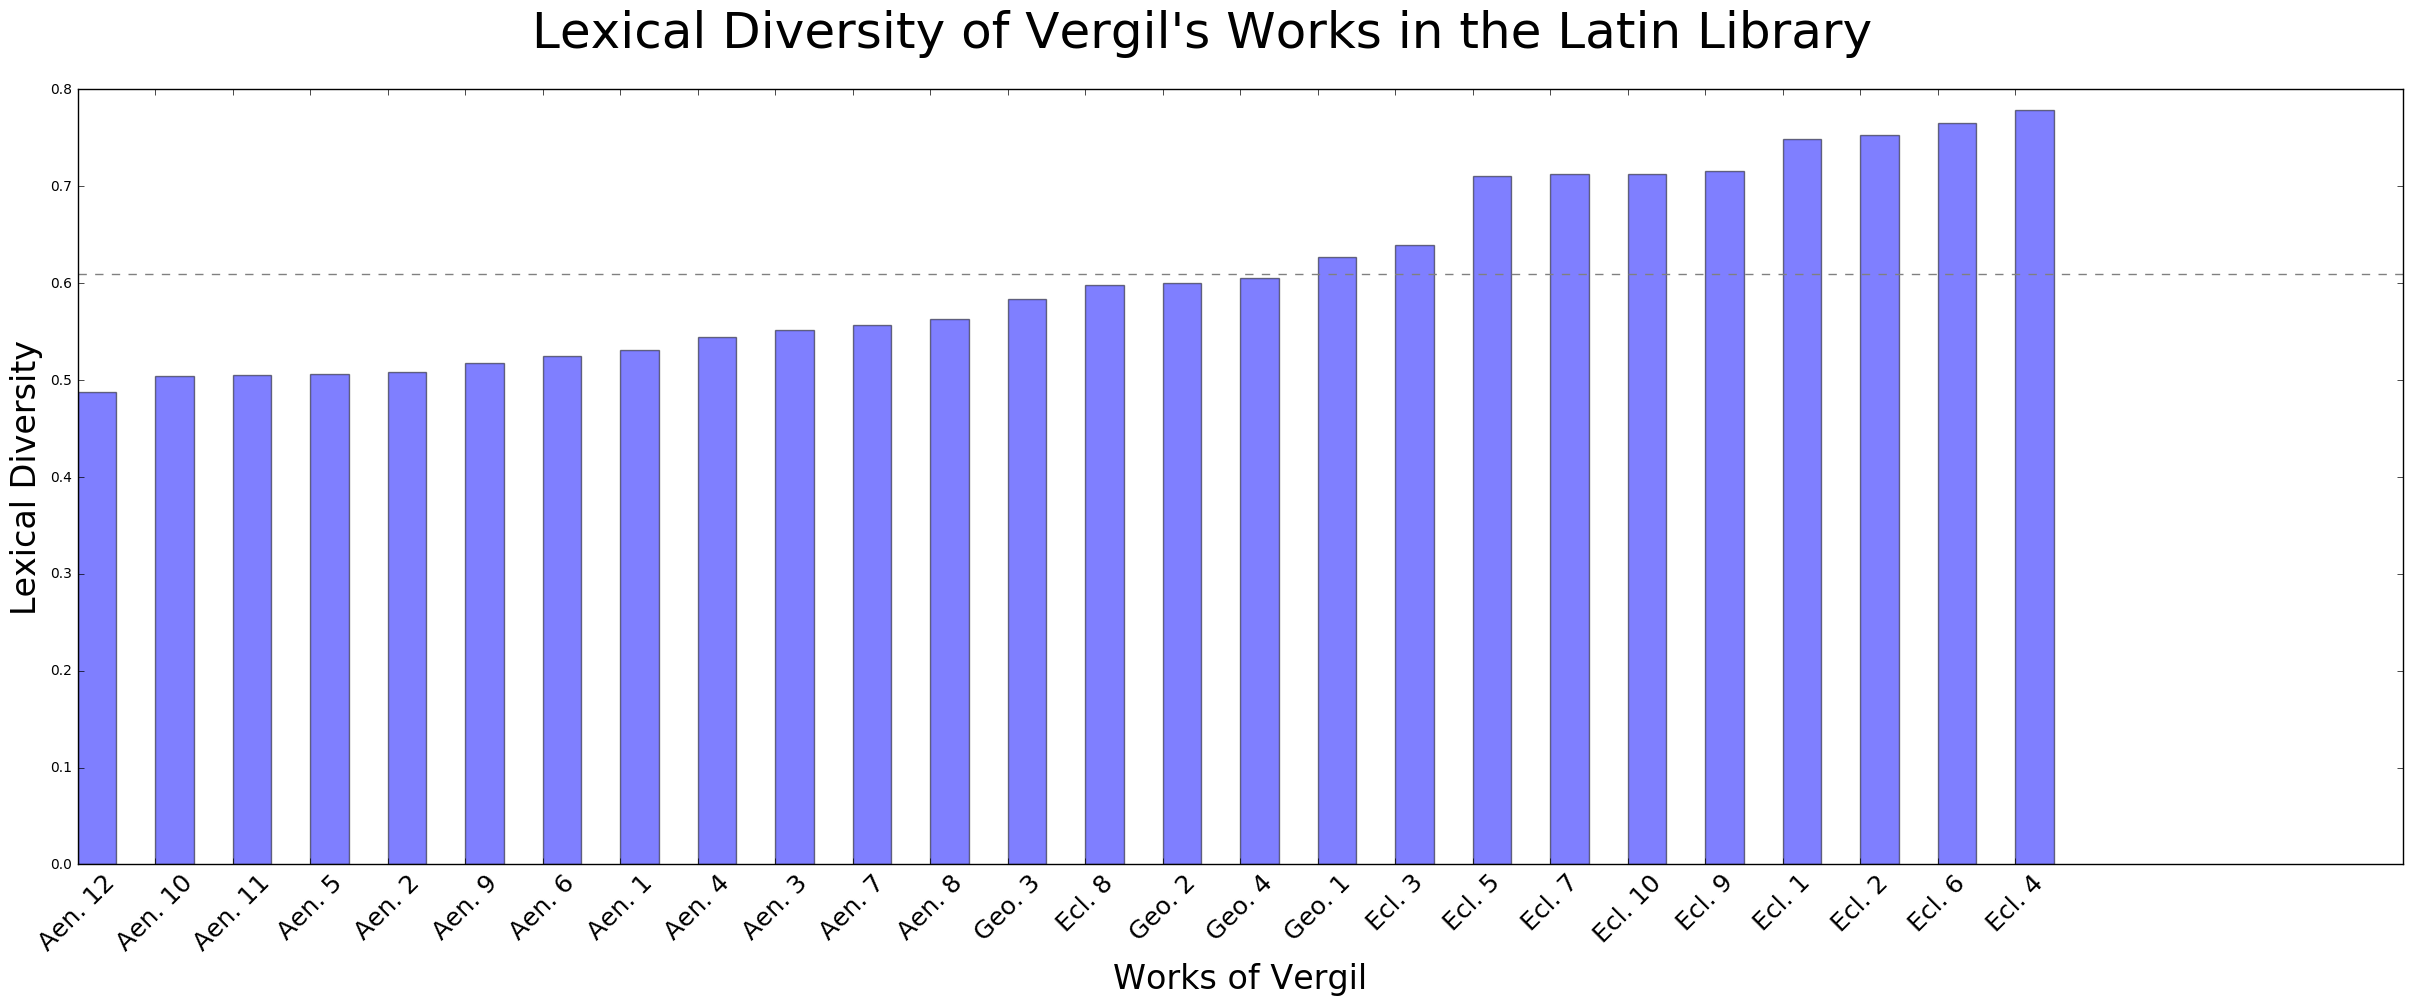

In [108]:
objects = [item[0] for item in lexdivs]
scores = [item[1] for item in lexdivs]
min_score = min(scores)
mean_score = np.mean(scores)
max_score = max(scores)

print('Min: ', min_score, '(', objects[scores.index(min_score)], ')')
print('Mean: ', mean_score)
print('Max: ', max_score, '(', objects[scores.index(max_score)], ')')

y_pos = np.arange(len(objects))
plt.figure(figsize=(30,10))

barlist = plt.bar(y_pos, scores, alpha=.5, align='edge', width=0.5)

#plt.bar(range(len(my_dict)), my_dict.values(), align='edge', width=0.3)

plt.xticks(y_pos, objects)
plt.axhline(y=mean_score,color='gray',ls='dashed')
plt.suptitle('Lexical Diversity of Vergil\'s Works in the Latin Library', fontsize=36)
plt.xlabel('Works of Vergil', fontsize = 24)
plt.ylabel('Lexical Diversity', fontsize = 24)

locs, labels = plt.xticks()
plt.setp(labels, fontsize=18, rotation=45)

plt.show()

This chart gives us a (very) rough idea of how wide a vocabulary Cicero's uses in different works, which is a step in the right direction for assessing "classic" readability.

## Readability Measurements, 1: Formal Features

Since the middle of the 20th-century there have been many formulas devised to measure the relative ease or difficulty of texts. I have written Python functions for several of these formulas. There is no need to go into the rationale behind each formula for the sake of today's talk, primarily because the result itself here is meaningless: the coefficients are based on English and the distributions of word, syllable, sentence, etc. length in English. That said, since they have been tested, used, and compared to each other on another natural language, I will work under the assumption that they are useful in giving relative and comparative data. In other words, the score itself can be ignored, but the fact that one work has a higher or lower score than another work should still give us an idea of which is more "readable."

This first set of formulas works with the first measurement of "classic" readability, i.e. counts of formal features. Here are some Python functins for getting counts of basic text features, spec. number of sentences, words, characters, syllables, and "difficult words" (or words with more than 3 syllables).

In [109]:
def sent_count(text):
    sents = sent_tokenizer.tokenize(text)
    return(len(sents))

def word_count(text):
    words = word_tokenizer.tokenize(text)
    return(len(words))

def char_count(text):
    return len(text)

def syll_count(text):
    return sum(letter in 'aeiouy' for letter in text.lower())

def comp_word_count(text):
    words = text.split()
    comp_words = [word for word in words if syll_count(word) > 3]
    return len(comp_words)

Here are formulas for the following readability measurements:
    - Automated readability index (Senter & Smith 1967)
    - Gunning fog index (Gunning 1952)
    - Flesch-Kincaid grade level (Kincaid et al. 1975)
    - Coleman-Liau index (Coleman & Liau 1975)

In [110]:
def ari(text):
    c, w, s = char_count(text), word_count(text), sent_count(text)
    score = 4.71 * (c / w) + 0.5 * (w / s) - 21.43
    return score

In [111]:
def gunningfog(text):
    w, s, cw = word_count(text), sent_count(text), comp_word_count(text)
    score = 0.4 * ((w / s) + (100 * (cw / w)))
    return score

In [112]:
def fleschkincaid(text):
    w, s, sy = word_count(text), sent_count(text), syll_count(text)
    score = (0.39 * (w / s)) + (11.8 * (sy / w)) - 15.59
    return score

In [113]:
def coleman_liau(text):
    c, w, s = char_count(text), word_count(text), sent_count(text)
    cs, ss = (c / w) * 100, (s / w) * 100
    score = (0.0588 * cs) - (0.296 * ss) - 15.8
    return score

In [115]:
aris = []

for i, text in enumerate(vergil_texts):
    #text = "\n".join(paras)
    aris.append((vergil_titles[i],ari(text)))
    
           
aris.sort(key=lambda x: x[1])
pprint(aris[:5])               
pprint(aris[-5:])

[('Ecl. 3', 13.481140621673411),
 ('Ecl. 2', 14.217485305392287),
 ('Ecl. 8', 14.222714983351828),
 ('Ecl. 9', 14.722776869158878),
 ('Ecl. 5', 16.777177777777773)]
[('Aen. 7', 20.67230560815188),
 ('Geo. 3', 21.078257107440677),
 ('Geo. 4', 21.34945221523561),
 ('Geo. 2', 21.426656935896936),
 ('Geo. 1', 23.322324211245352)]


Min:  8.518604266068955
Mean:  18.7344104293
Max:  31.029355209322325


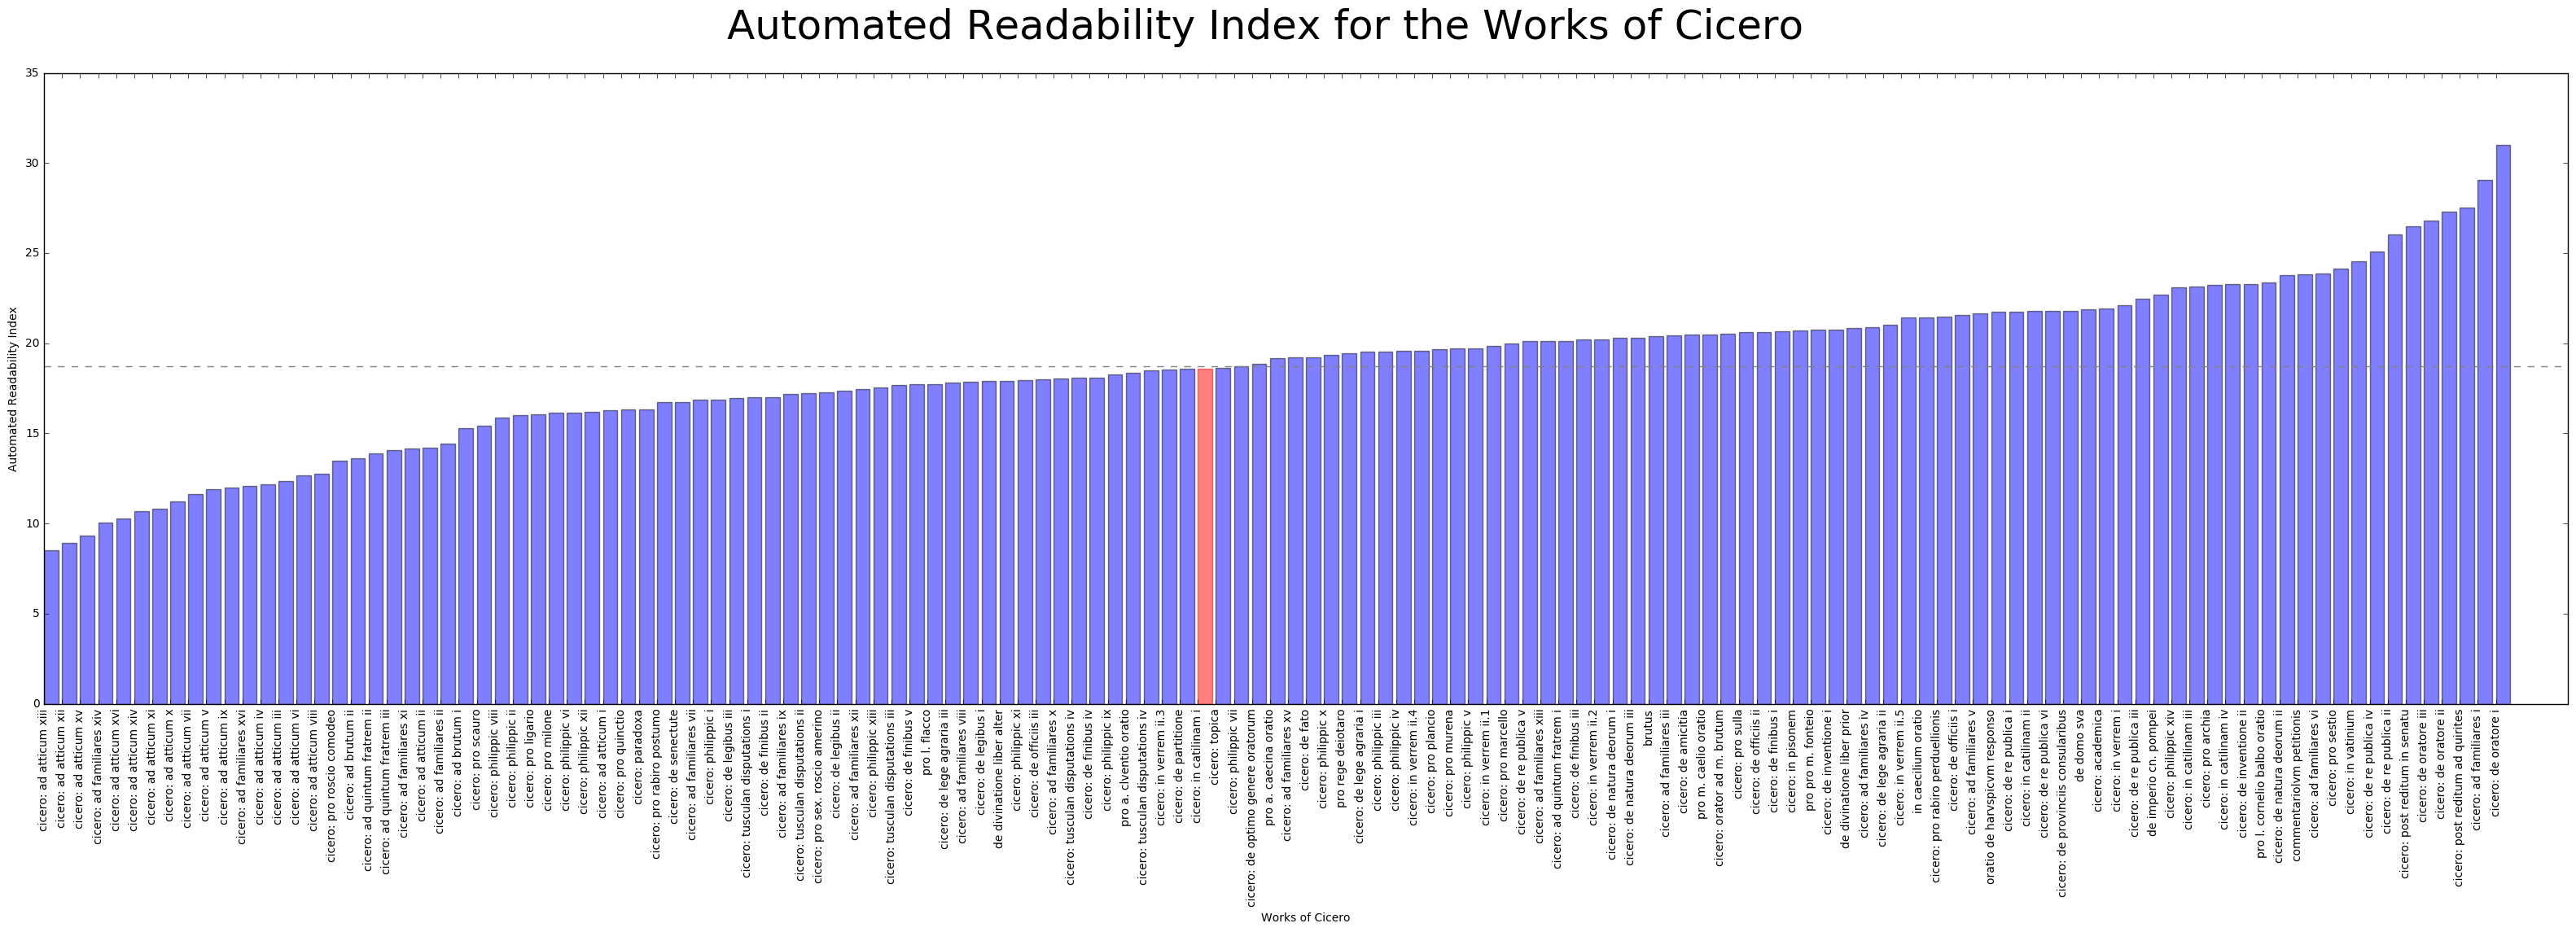

In [28]:
test = "Automated Readability Index"

objects = [item[0] for item in aris]
scores = [item[1] for item in aris]
min_score = min(scores)
mean_score = np.mean(scores)
max_score = max(scores)

print('Min: ', min_score, '(', objects[scores.index(min_score)], ')')
print('Mean: ', mean_score)
print('Max: ', max_score, '(', objects[scores.index(max_score)], ')')

y_pos = np.arange(len(objects))
plt.figure(figsize=(40,10))
barlist = plt.bar(y_pos, scores, alpha=.5)
barlist[objects.index('cicero: in catilinam i')].set_color('r')

plt.xticks(y_pos, objects)
plt.axhline(y=mean_score,color='gray',ls='dashed')
plt.suptitle('%s for the Works of Cicero' % test, fontsize=36)
plt.xlabel('Works of Cicero')
plt.ylabel(test)

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.show()

In [29]:
gfs = []

for i, paras in enumerate(cicero_paras):
    text = "\n".join(paras)
    gfs.append((cicero_titles[i],gunningfog(text)))
    
           
gfs.sort(key=lambda x: x[1])
pprint(gfs[:5])               
pprint(gfs[-5:])

[('cicero: ad atticum xiii', 9.127952085762171),
 ('cicero: ad atticum xii', 9.438213409409675),
 ('cicero: ad atticum xv', 9.93396248054395),
 ('cicero: ad atticum xi', 10.253558538387052),
 ('cicero: ad familiares xiv', 10.57960845798946)]
[('cicero: de oratore iii', 23.103391605328667),
 ('cicero: de oratore ii', 23.588741384446013),
 ('cicero: post reditum ad quirites', 24.284480919008608),
 ('cicero: ad familiares i', 25.341200608762485),
 ('cicero: de oratore i', 26.611089173241858)]


Min:  9.127952085762171
Mean:  17.0619875993
Max:  26.611089173241858


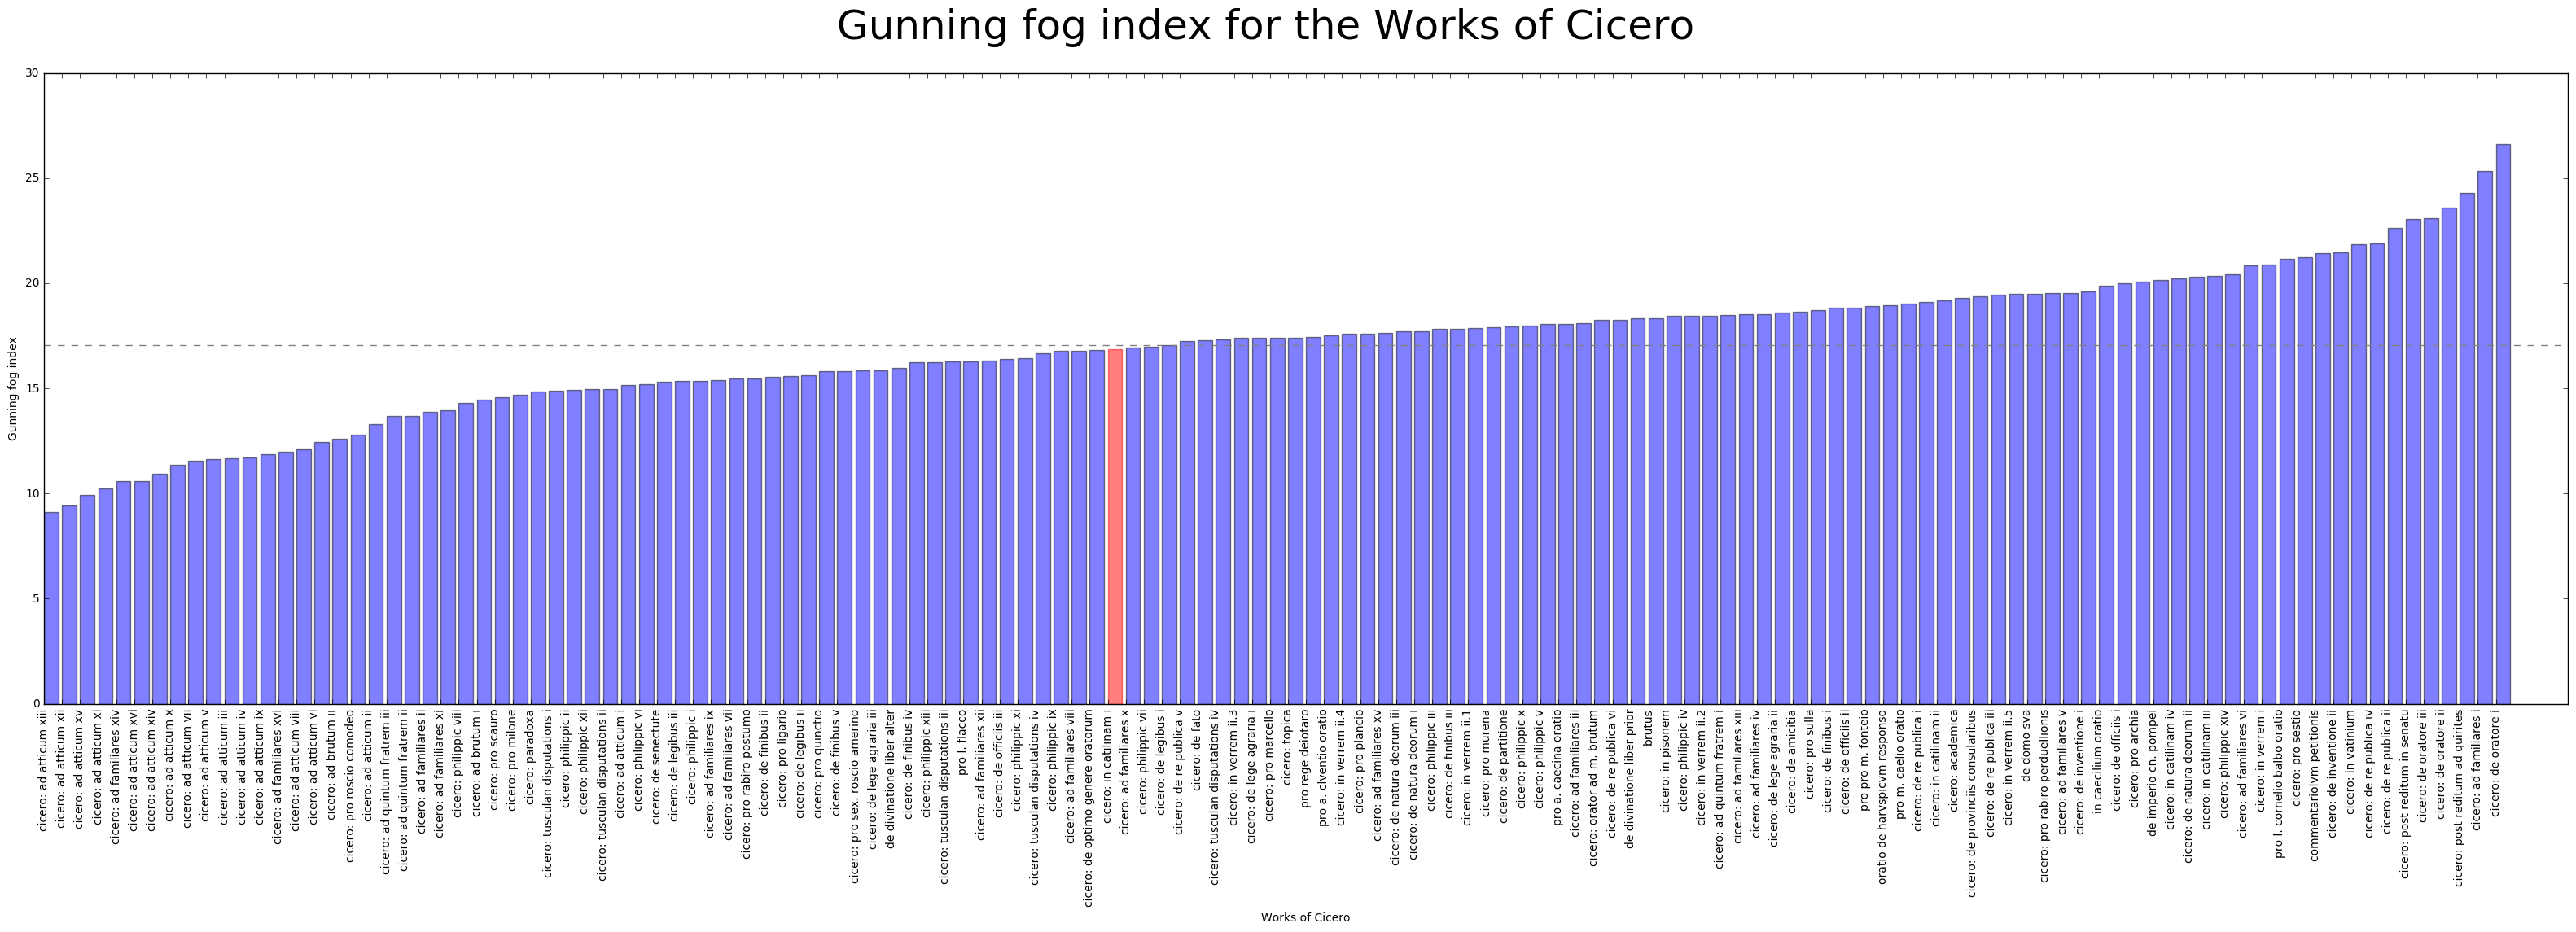

In [30]:
test = "Gunning fog index"

objects = [item[0] for item in gfs]
scores = [item[1] for item in gfs]
min_score = min(scores)
mean_score = np.mean(scores)
max_score = max(scores)

print('Min: ', min_score, '(', objects[scores.index(min_score)], ')')
print('Mean: ', mean_score)
print('Max: ', max_score, '(', objects[scores.index(max_score)], ')')

y_pos = np.arange(len(objects))
plt.figure(figsize=(40,10))
barlist = plt.bar(y_pos, scores, alpha=.5)
barlist[objects.index('cicero: in catilinam i')].set_color('r')

plt.xticks(y_pos, objects)
plt.axhline(y=mean_score,color='gray',ls='dashed')
plt.suptitle('%s for the Works of Cicero' % test, fontsize=36)
plt.xlabel('Works of Cicero')
plt.ylabel(test)

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.show()

In [31]:
fks = []

for i, paras in enumerate(cicero_paras):
    text = "\n".join(paras)
    fks.append((cicero_titles[i],fleschkincaid(text)))
    
           
fks.sort(key=lambda x: x[1])
pprint(fks[:5])               
pprint(fks[-5:])

[('cicero: ad atticum xiii', 11.397322175228652),
 ('cicero: ad atticum xii', 11.936971087306954),
 ('cicero: ad atticum xv', 12.34724772671418),
 ('cicero: ad familiares xiv', 12.749659923391352),
 ('cicero: ad atticum xvi', 13.385129129015834)]
[('cicero: de oratore iii', 27.73675182259611),
 ('cicero: de oratore ii', 28.119757955764054),
 ('cicero: post reditum ad quirites', 28.457473854411962),
 ('cicero: ad familiares i', 29.333325668610787),
 ('cicero: de oratore i', 31.296026477510555)]


Min:  11.397322175228652
Mean:  21.0390908453
Max:  31.296026477510555


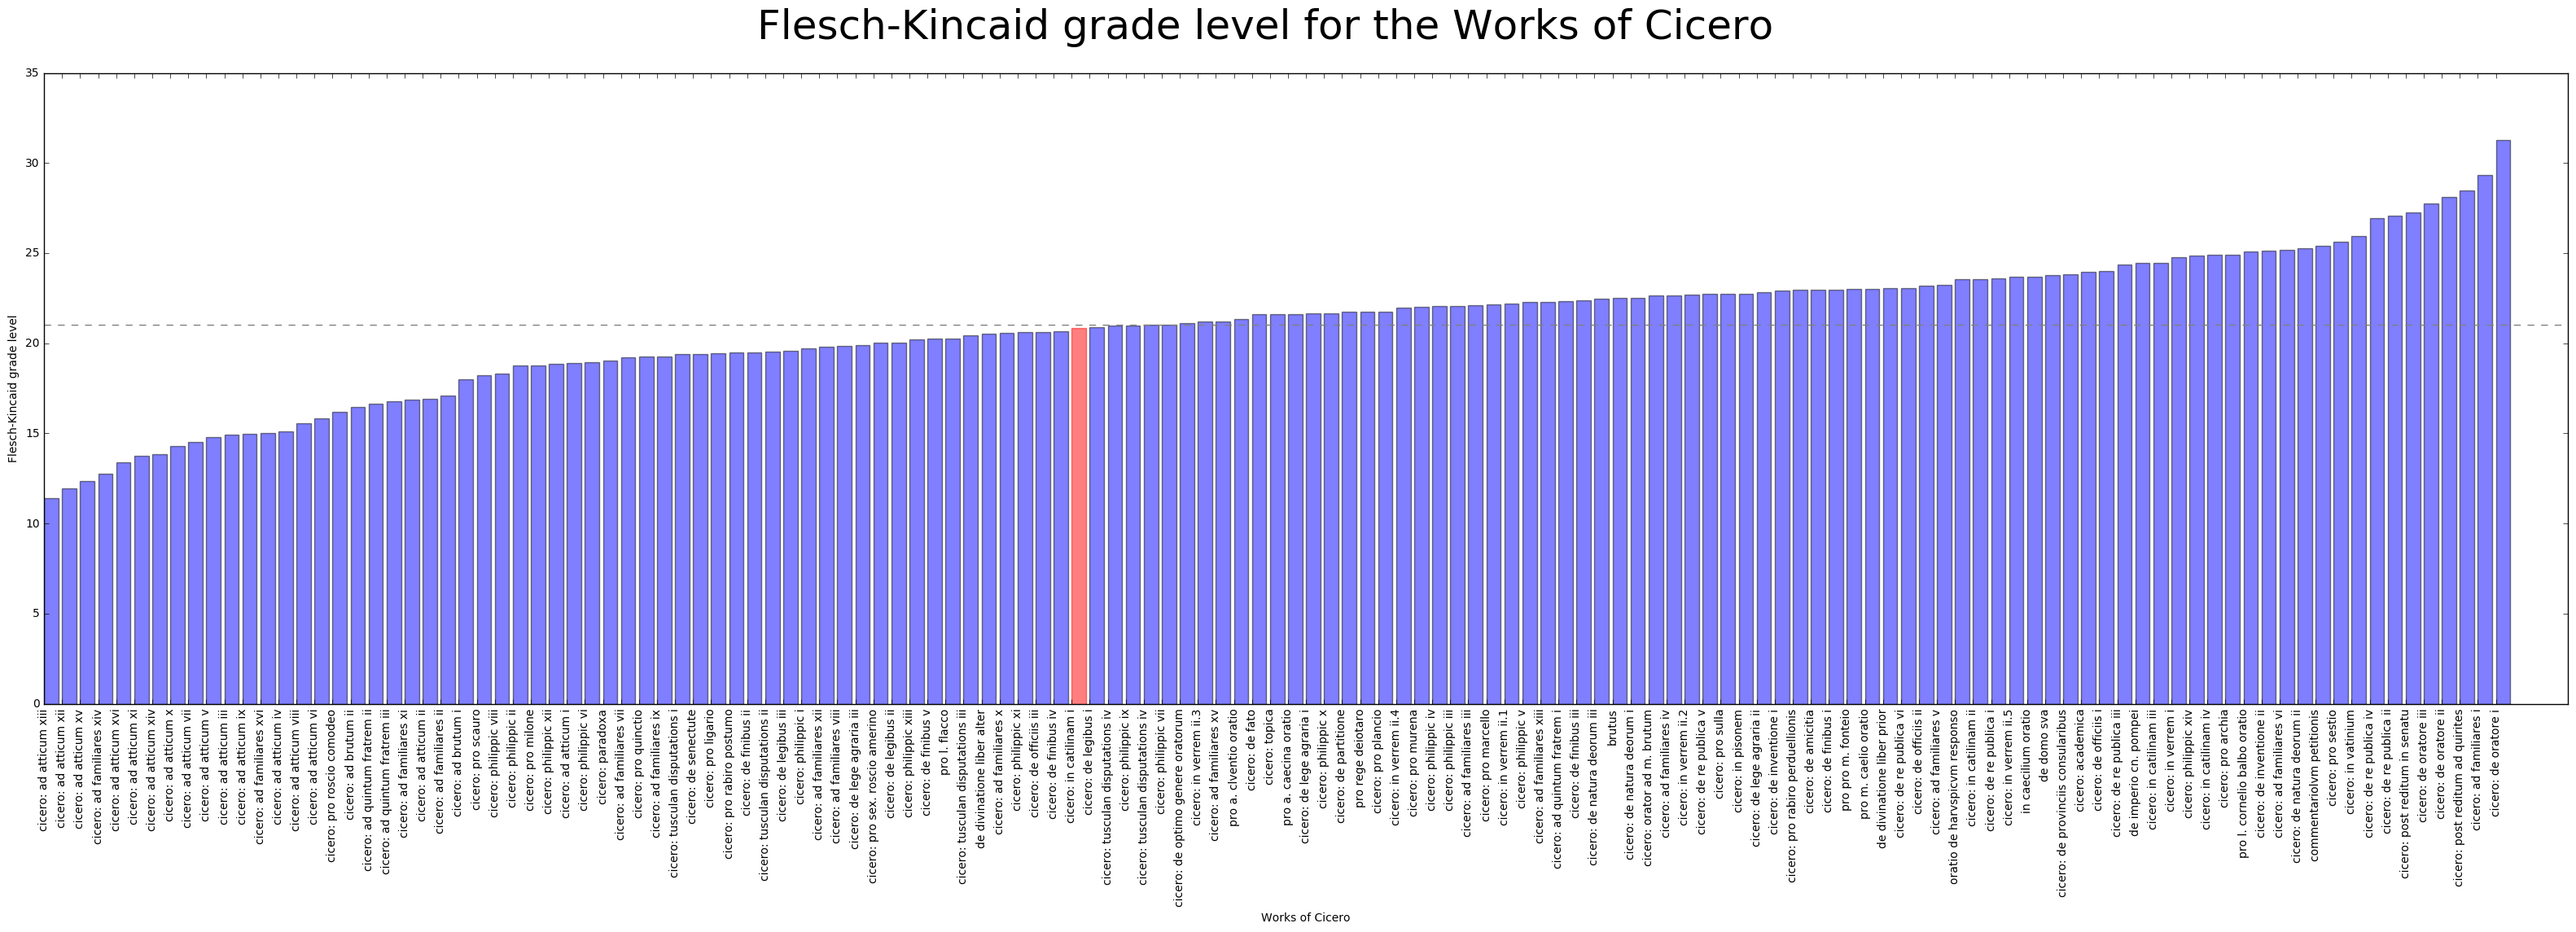

In [32]:
test = "Flesch-Kincaid grade level"

objects = [item[0] for item in fks]
scores = [item[1] for item in fks]
min_score = min(scores)
mean_score = np.mean(scores)
max_score = max(scores)

print('Min: ', min_score, '(', objects[scores.index(min_score)], ')')
print('Mean: ', mean_score)
print('Max: ', max_score, '(', objects[scores.index(max_score)], ')')

y_pos = np.arange(len(objects))
plt.figure(figsize=(40,10))
barlist = plt.bar(y_pos, scores, alpha=.5)
barlist[objects.index('cicero: in catilinam i')].set_color('r')

plt.xticks(y_pos, objects)
plt.axhline(y=mean_score,color='gray',ls='dashed')
plt.suptitle('%s for the Works of Cicero' % test, fontsize=36)
plt.xlabel('Works of Cicero')
plt.ylabel(test)

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.show()

In [33]:
cls = []

for i, paras in enumerate(cicero_paras):
    text = "\n".join(paras)
    cls.append((cicero_titles[i],coleman_liau(text)))
    
           
cls.sort(key=lambda x: x[1])
pprint(cls[:5])               
pprint(cls[-5:])

[('cicero: ad atticum xiii', 12.441305222640182),
 ('cicero: ad atticum xii', 12.765881164477918),
 ('cicero: ad atticum xv', 13.234013271073973),
 ('cicero: ad familiares xiv', 13.869518455145446),
 ('cicero: ad atticum xvi', 14.132220566318928)]
[('cicero: in catilinam iv', 21.36215293731539),
 ('cicero: post reditum in senatu', 21.681293729372936),
 ('cicero: philippic xiv', 22.016496674057645),
 ('cicero: post reditum ad quirites', 22.117553384002893),
 ('cicero: de re publica iv', 22.825120772946857)]


Min:  12.441305222640182
Mean:  18.9562778128
Max:  22.825120772946857


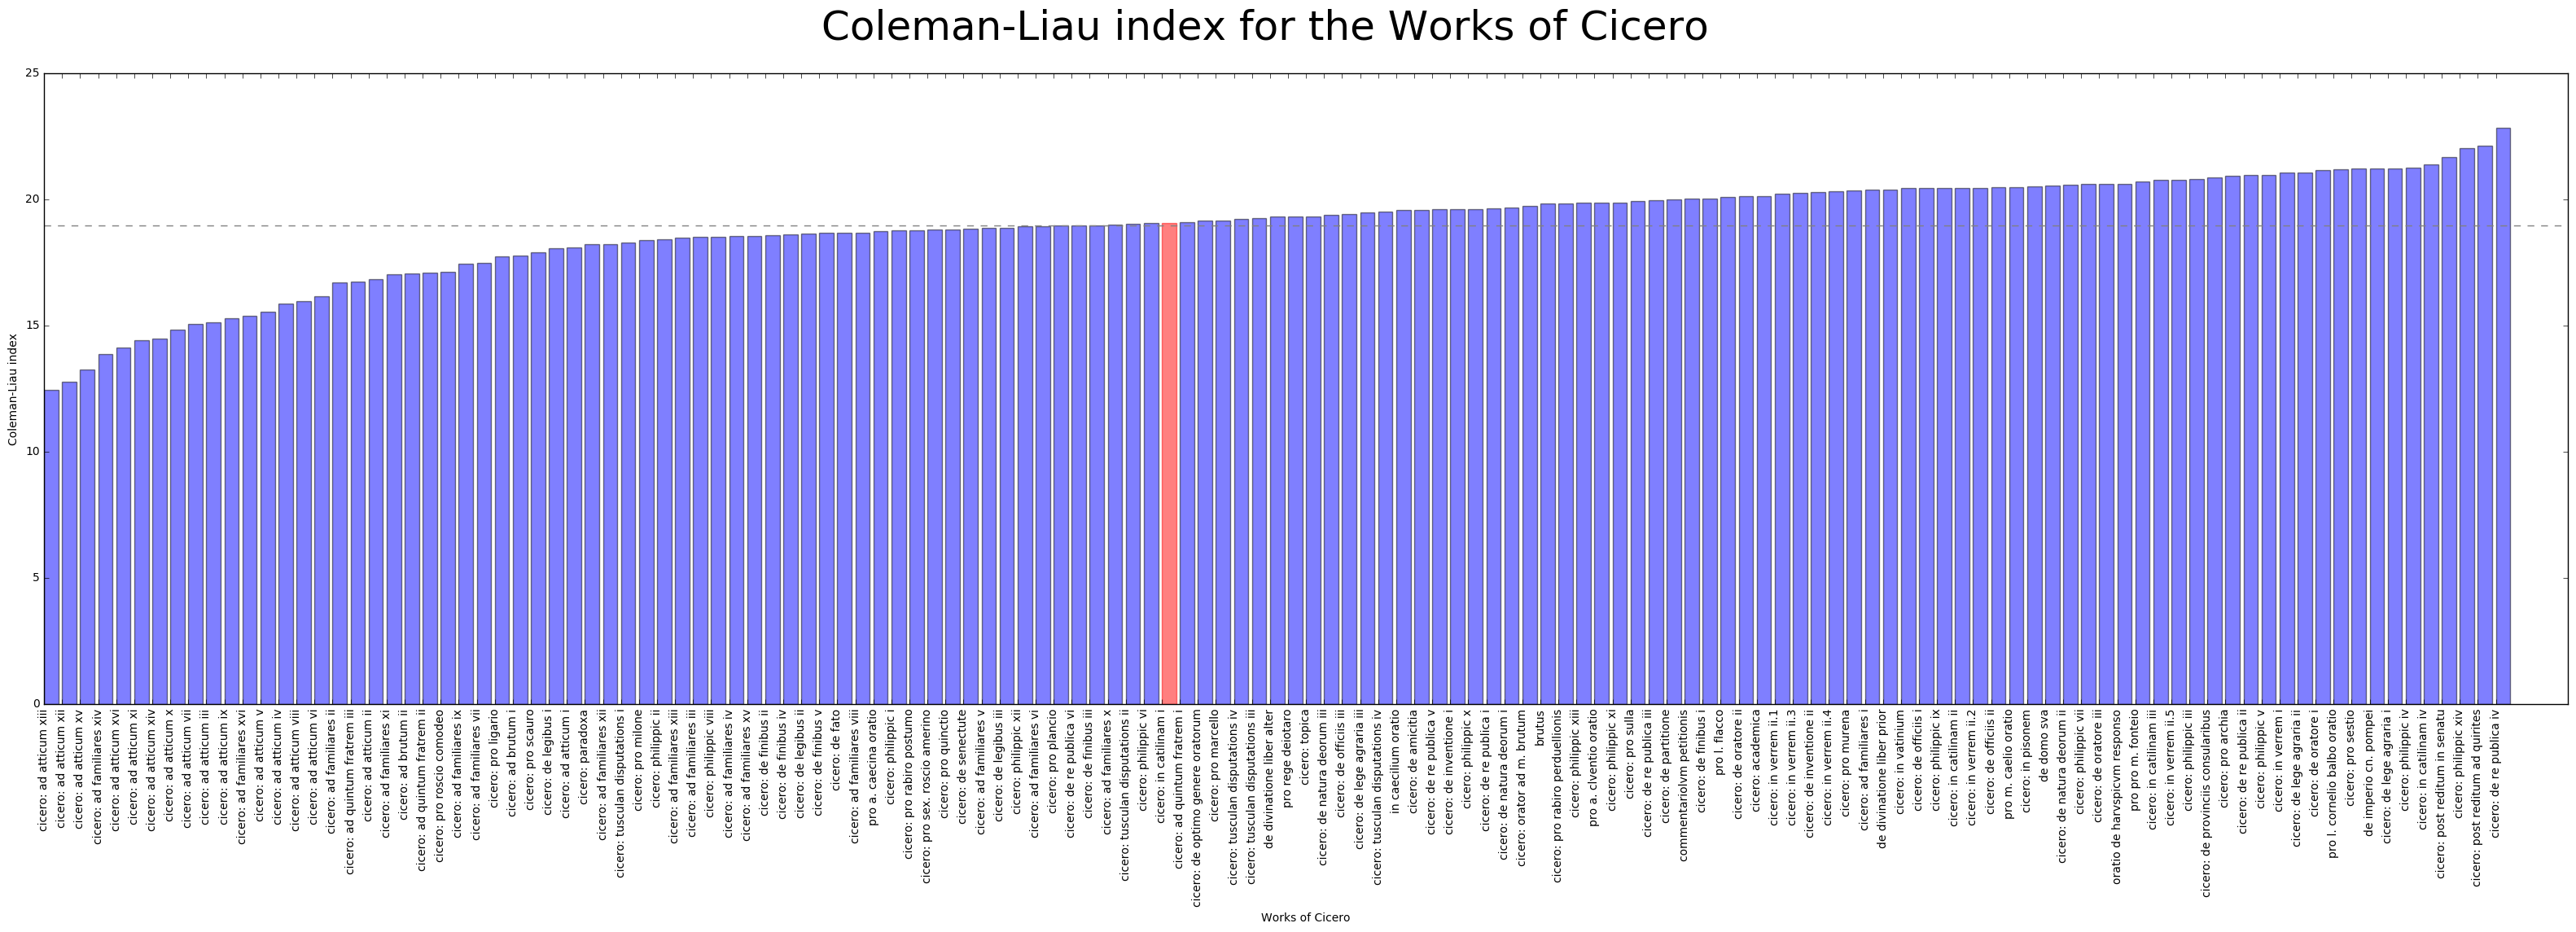

In [34]:
test = "Coleman-Liau index"

objects = [item[0] for item in cls]
scores = [item[1] for item in cls]
min_score = min(scores)
mean_score = np.mean(scores)
max_score = max(scores)

print('Min: ', min_score, '(', objects[scores.index(min_score)], ')')
print('Mean: ', mean_score)
print('Max: ', max_score, '(', objects[scores.index(max_score)], ')')

y_pos = np.arange(len(objects))
plt.figure(figsize=(40,10))
barlist = plt.bar(y_pos, scores, alpha=.5)
barlist[objects.index('cicero: in catilinam i')].set_color('r')

plt.xticks(y_pos, objects)
plt.axhline(y=mean_score,color='gray',ls='dashed')
plt.suptitle('%s for the Works of Cicero' % test, fontsize=36)
plt.xlabel('Works of Cicero')
plt.ylabel(test)

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.show()

## Readability Measurements, 2: Lexical Difficulty

The tests we have looked at so far are all variations on a theme, i.e. they all measure formal features of texts. They all rely on counting characters, words, syllables, and sentences and then processing them algorithmically to determine their readability score. The second feature associated with "classic readability" is lexical difficulty. And for our last exploration of our corpus today, let's look at how the words themselves of a sentence can be used to measure difficulty with the Dale-Chall test.

The Dale-Chall test uses a list of 3,000 "common" words. As a substitute index of common Latin words, I have used the Dickinson Core Latin Vocabulary (http://dcc.dickinson.edu/latin-vocabulary-list), a list of ~1000 "dictionary headwords that generate approximately 70% of the word forms in a typical Latin text."

First, I have taken the .csv file that is available from the DCC site and extracted the lemmas into a reference list.

In [48]:
import csv
from collections import defaultdict

datapath = 'data/'
datafile = "latin_vocabulary_list.csv"

# Load first column of DCC Core Vocabulary csv file
columns = defaultdict(list)

with open(datapath+datafile) as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        for (i,v) in enumerate(row):
            columns[i].append(v)

dcc_lemmas = columns[0]

# Split headword column by whitespace and keep only first word
dcc_lemmas_simple = [lemma.replace('/',' ').split()[0] for lemma in dcc_lemmas]

In [49]:
# Preprocess DCC lemmas

# Normalize u/v
dcc_lemmas_simple = [replacer.replace(lemma) for lemma in dcc_lemmas_simple]

# remove macrons
def remove_macrons(text):
    transmap = {ord('ā'): 'a', ord('ē'): 'e', ord('ī'): 'i', ord('ō'): 'o', ord('ū'): 'u', }
    return text.translate(transmap)

dcc_lemmas_simple = [remove_macrons(lemma) for lemma in dcc_lemmas_simple]

# Remove punctuation
translator = str.maketrans({key: None for key in string.punctuation})
dcc_lemmas_simple = [lemma.translate(translator) for lemma in dcc_lemmas_simple]

dcc_lemmas_simple.sort()  

In [50]:
print(dcc_lemmas_simple[:25])

['a', 'abeo', 'absum', 'ac', 'accedo', 'accido', 'accipio', 'acer', 'acies', 'ad', 'addo', 'adduco', 'adeo', 'adeo', 'adhibeo', 'adhuc', 'adsum', 'aduenio', 'aduersus', 'aduersus', 'aduerto', 'aedes', 'aeger', 'aegre', 'aeque']


In [51]:
# Postprocess lemmas
def postprocess_lemmas(lemmas):
    translator = str.maketrans({key: "" for key in '0123456789'})
    lemmas = [lemma.translate(translator) for lemma in lemmas]
    lemmas = [replacer.replace(lemma) for lemma in lemmas]
    return lemmas

The Dale-Chall formula accounts for both formal features like the tests above, but also has a variable called "difficult words," defined as a word that does not appear in the reference list. Here is a formula for finding difficult words:

In [52]:
def difficult_words(text):
    tokens = word_tokenizer.tokenize(text)
    lemmas = lemmatizer.lemmatize(tokens)
    lemmas = [lemma[1] for lemma in lemmas if lemma[1] != 'punc']
    lemmas = postprocess_lemmas(lemmas)
    difficult_words = [lemma for lemma in lemmas if lemma not in dcc_lemmas_simple]
    #print(difficult_words)
    return len(difficult_words)

And here is the formula for calculating the Dale-Chall score:

In [53]:
def dalechall(text):
    w, s, dw = word_count(text), sent_count(text), difficult_words(text)
    return (0.1579 * ((dw / w) * 100)) + (0.0496 * (w / s))

In [50]:
# This runs slowly

dcs = []

for i, paras in enumerate(cicero_paras):
    text = "\n".join(paras)
    dcs.append((cicero_titles[i],dalechall(text)))
              
dcs.sort(key=lambda x: x[1])
pprint(dcs[:5])               
pprint(dcs[-5:])

[('cicero: ad atticum xi', 3.6730632862944126),
 ('cicero: pro ligario', 3.8382744976778738),
 ('cicero: de finibus ii', 3.916527953707158),
 ('cicero: ad brutum ii', 3.9225264975988994),
 ('cicero: ad atticum iii', 4.036277898410491)]
[('cicero: de natura deorum ii', 5.731801662882605),
 ('cicero: de re publica ii', 5.807654468409794),
 ('cicero: de re publica iv', 5.814713871635611),
 ('cicero: de oratore i', 5.832601853149253),
 ('de divinatione liber prior', 5.905094241384619)]


Min:  3.6730632862944126
Mean:  4.75826139127
Max:  5.905094241384619


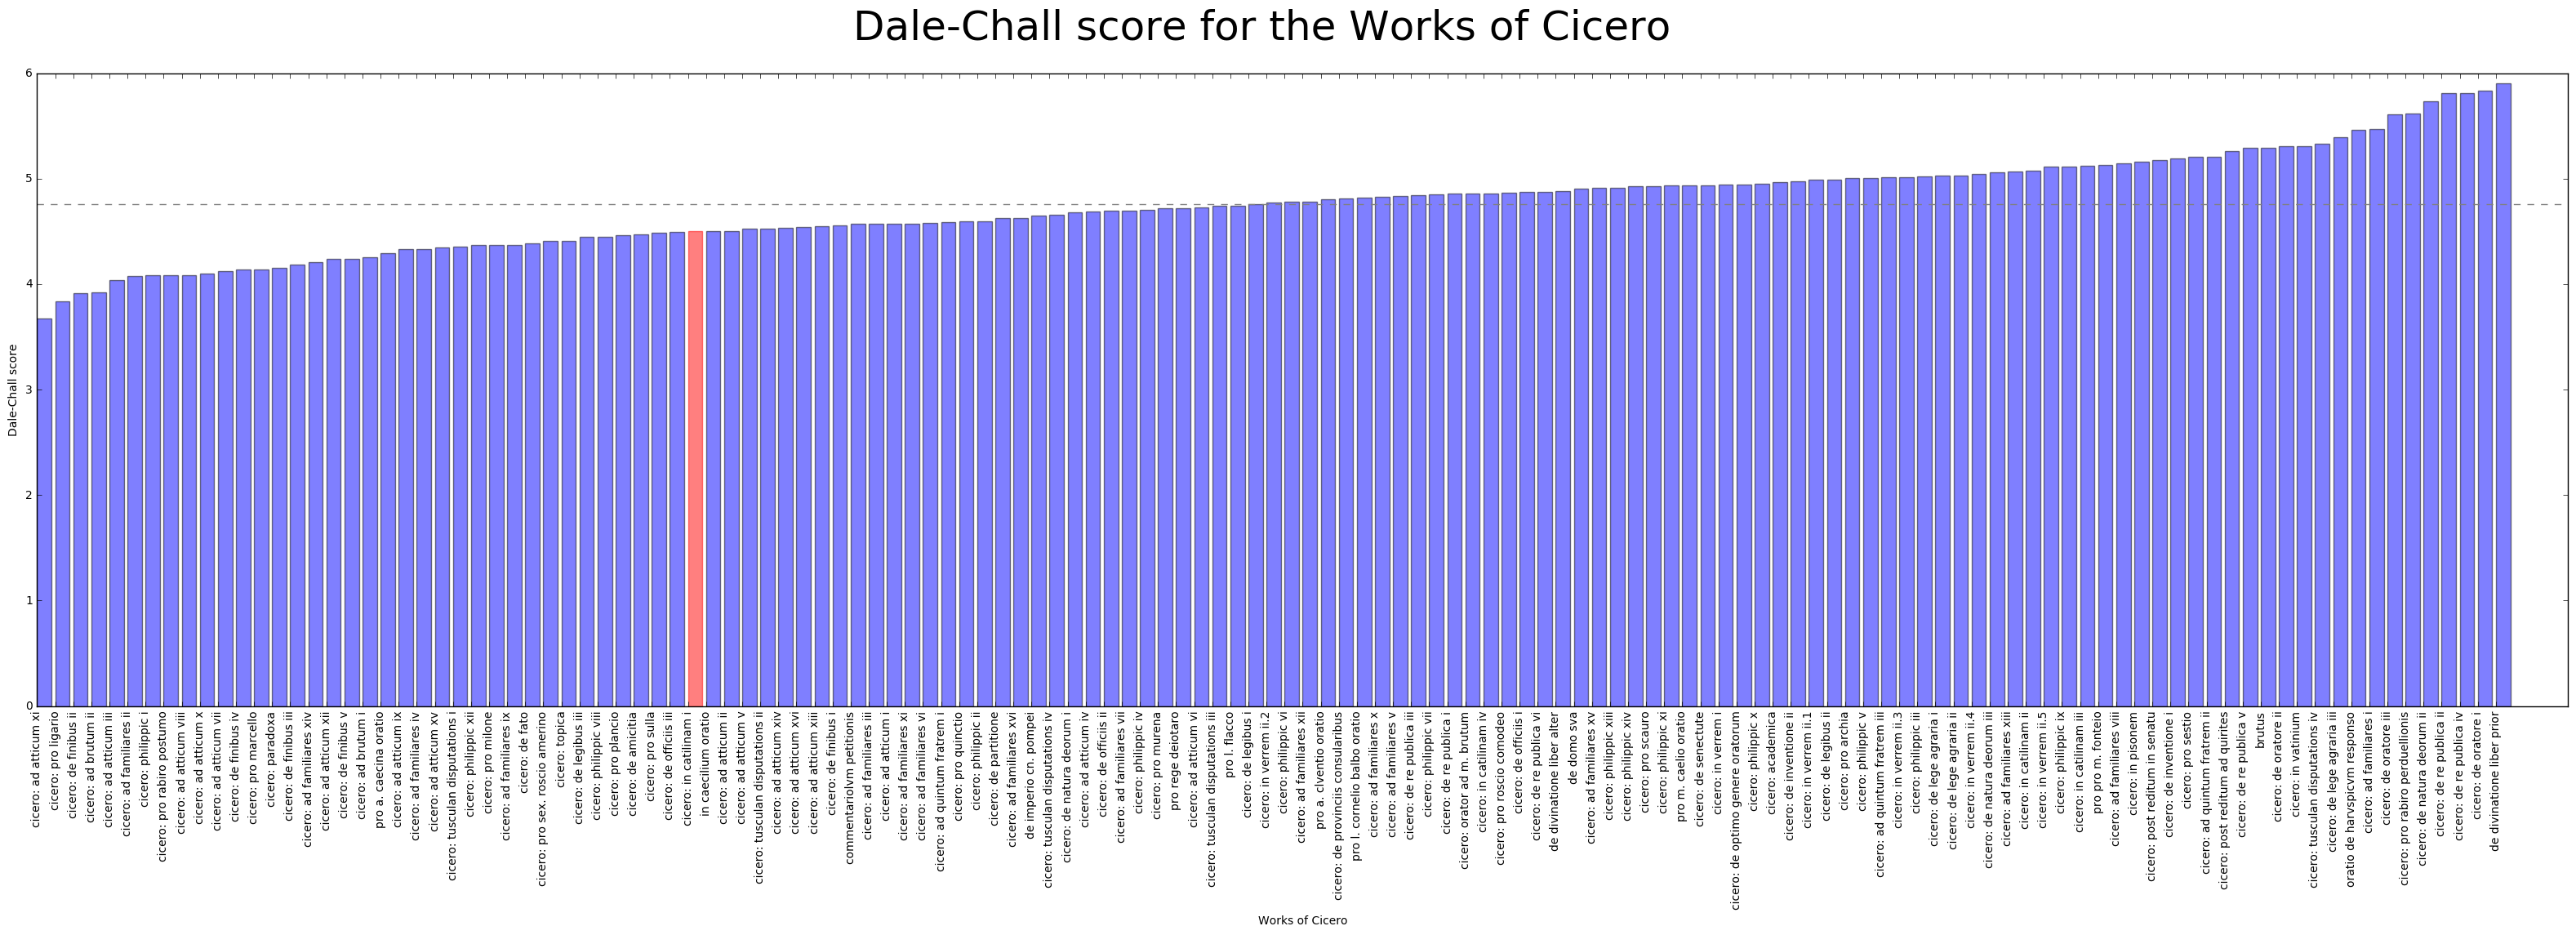

In [51]:
test = "Dale-Chall score"

objects = [item[0] for item in dcs]
scores = [item[1] for item in dcs]
min_score = min(scores)
mean_score = np.mean(scores)
max_score = max(scores)

print('Min: ', min_score, '(', objects[scores.index(min_score)], ')')
print('Mean: ', mean_score)
print('Max: ', max_score, '(', objects[scores.index(max_score)], ')')

y_pos = np.arange(len(objects))
plt.figure(figsize=(40,10))
barlist = plt.bar(y_pos, scores, alpha=.5)
barlist[objects.index('cicero: in catilinam i')].set_color('r')

plt.xticks(y_pos, objects)
plt.axhline(y=mean_score,color='gray',ls='dashed')
plt.suptitle('%s for the Works of Cicero' % test, fontsize=36)
plt.xlabel('Works of Cicero')
plt.ylabel(test)

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.show()

## Hardest sentence?

In [41]:
cicero_sents_flat = [sent for sents in cicero_sents for sent in sents]
cicero_sents_flat = [sent for sents in cicero_sents_flat for sent in sents]

In [43]:
aris = []

for sent in cicero_sents_flat:
    aris.append((sent,ari(sent)))
    
aris.sort(key=lambda x: x[1])             
pprint(aris[-1:])

[('liii nam et commoratio una in re permultum movet et inlustris explanatio '
  'rerumque quasi gerantur sub aspectum paene subiectio quae et in exponenda '
  're plurimum valent et ad inlustrandum id quod exponitur et ad amplificandum '
  'ut eis qui audient illud quod augebimus quantum efficere oratio poterit '
  'tantum esse videatur et huic contraria saepe percursio est et plus ad '
  'intellegendum quam dixeris significatio et distincte concisa brevitas et '
  'extenuatio et huic adiuncta inlusio a praeceptis caesaris non abhorrens et '
  'ab re digressio in qua cum fuerit delectatio tum reditus ad rem aptus et '
  'concinnus esse debebit propositioque quid sis dicturus et ab eo quod est '
  'dictum seiunctio et reditus ad propositum et iteratio et rationis apta '
  'conclusio tum augendi minuendive causa veritatis supralatio atque traiectio '
  'et rogatio atque huic finitima quasi percontatio eitioque sententiae suae '
  'tum illa quae maxime quasi inrepit in hominum mentis alia

In [85]:
print(len(aris[-1][0]), "characters")
print(len(aris[-1][0].split()), "words")
print(len(aris[-1][0]) / len(aris[-1][0].split()), "chars per word")

1919 characters
280 words
6.853571428571429 chars per word


So, is *De oratore* 3.202-205 the most difficult sentence in Cicero?

## Challenges with historical languages

Latin, classical Greek, and other historical languages present unique challenges when approaching readability. The two main difficulties are:

- Fewer expert readers (and no native readers); much of the literature on English readability is built upon the assumptions that:
    1. children develop a working vocabulary naturally over the course of many years, primarily without the assistance of formal education
    2. children develop (again with formal education) an ability to form on the one hand and recognize on the other sentences of increasing complexity
    3. children are surrounded by adult expert users of the language to offer a model and source of continuous, often informal correction
- All Latin words are learned in formal educational contexts; cf. the 3,000 D-C wordlist
- Compressed time line for developing "proficiency," also in formal educational contexts
- Much less standardized testing data for comparison and cross-validation

## Next Steps

Some ideas of where to go next with readability studies for Latin/Greek:
- Identification / development of "criterion passages"
    - i.e. passages rated on an "independent measure such as a test of reading comprehension, rate of reading, or judgments of difficulty.
- Improved, expanded word lists
- Increase attention to the role of the other primary domains of readability studies: the reader and the context.

## Conclusion

"It should be remembered that readability formulas estimate difficulty on the basis of factors that have the highest prediction of difficulty. ...No readability formula is a complete and full measure of text difficulty." Chall & Dale 1995, 5-6

In [ ]:
text = preprocess(latinlibrary.raw('vergil/aen1.txt'))
print(text[:1000])
sents = tsplit(text, ['.\n', '.', '?', '!'])
print(len(sents))
lps = [sent.count('\n') for sent in sents]
print(lps)
print(sum(lps) / len(lps))

for file in vergil_files:
    text = preprocess(latinlibrary.raw(file))
    sents = tsplit(text, ['.\n', '.', '?', '!'])
    lps = [sent.count('\n') for sent in sents]
    print(file, sum(lps)/len(lps))
    